# Import Packages

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 28.0 MB/s 
     |████████████████████████████████| 182 kB 58.8 MB/s 
     |████████████████████████████████| 7.6 MB 56.5 MB/s 


In [2]:
import pandas as pd
import numpy as np
import os
import string
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

# Import Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Erdos Fall 2022/Dataset/train.csv")
test_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Erdos Fall 2022/Dataset/test.csv")

In [5]:
train_dataset.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [6]:
train_dataset.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [7]:
cohesion = train_dataset['cohesion']
syntax = train_dataset['syntax']
vocabulary = train_dataset['vocabulary']
phraseology = train_dataset['phraseology']
grammar = train_dataset['grammar']
conventions = train_dataset['conventions']

In [15]:
syntax = np.asarray(syntax)
cohesion = np.asarray(cohesion)
vocabulary = np.asarray(vocabulary)
phraseology = np.asarray(phraseology)
grammar = np.asarray(grammar)
conventions = np.asarray(conventions)

## Clean the full_text

In [8]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
def CleanFeatures(sentences):
  sentences = sentences.apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
  sentences = sentences.apply(lambda wrd: ''.join(wrd))
  sentences = sentences.apply(lambda sequence:
                                            [word for word in sequence.split() if word not in stop_words])
  sentences = sentences.apply(lambda wrd: ' '.join(wrd))
  return sentences

In [10]:
full_text_train = CleanFeatures(train_dataset['full_text'])

In [11]:
full_text_test = CleanFeatures(test_dataset['full_text'])

# Tokenize Text

## Use BertTokenizer

In [19]:
from transformers import AutoTokenizer

In [20]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [28]:
tokens_train = []

In [29]:
for index, content in enumerate(full_text_train):
  tokens_train.append(tokenizer(content, max_length = 512, padding = "max_length",
                                 truncation = True, return_token_type_ids = True,
                                 return_tensors = 'np')['input_ids'])

In [34]:
tokens_train = np.asarray(tokens_train)

In [36]:
tokens_train.shape

(3911, 1, 512)

In [37]:
tokens_train = np.reshape(tokens_train, (tokens_train.shape[0], tokens_train.shape[2]))

In [38]:
tokens_train.shape

(3911, 512)

In [39]:
# save Bert Tokens for train
np.save("/content/drive/MyDrive/Colab Notebooks/Erdos Fall 2022/preprocessed_data/train_BertToken.npy",tokens_train)

In [40]:
# do the same to test data
tokens_test = []
for index, content in enumerate(full_text_test):
  tokens_test.append(tokenizer(content, max_length = 512, padding = "max_length",
                                 truncation = True, return_token_type_ids = True,
                                 return_tensors = 'np')['input_ids'])
tokens_test = np.asarray(tokens_test)
tokens_test = np.reshape(tokens_test, (tokens_test.shape[0], tokens_test.shape[2]))

In [42]:
# save Bert Tokens for test
np.save("/content/drive/MyDrive/Colab Notebooks/Erdos Fall 2022/preprocessed_data/test_BertToken.npy",tokens_test)

## Use bert-embedding

## Use Contextualized Word Embeddings From BERT

Reference: https://towardsdatascience.com/3-types-of-contextualized-word-embeddings-from-bert-using-transfer-learning-81fcefe3fe6d

# XGBRegressor

## Load Preprocessed Data

In [43]:
train_token = np.load("/content/drive/MyDrive/Colab Notebooks/Erdos Fall 2022/preprocessed_data/train_BertToken.npy")

In [44]:
test_token = np.load("/content/drive/MyDrive/Colab Notebooks/Erdos Fall 2022/preprocessed_data/test_BertToken.npy")

## XGB model and Train

In [71]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold

In [72]:
import xgboost as xgb

In [73]:
kfold = KFold(n_splits = 10,
              shuffle = True,
              random_state = 404)

In [74]:
y_train = np.transpose(np.asarray([cohesion, syntax, vocabulary, phraseology, grammar, conventions]))

In [85]:
cv_rmses = np.zeros((10,6))

# Use mean of rating as baseline to compare
cv_rmses_baseline = np.zeros((10,6))

i = 0
for train_ind, val_ind in kfold.split(train_token, y_train):
    x_t = train_token[train_ind]
    y_t = y_train[train_ind]
    
    x_val = train_token[val_ind]
    y_val = y_train[val_ind]
    
    xgb_estimator = xgb.XGBRegressor(n_estimators=500, 
        objective='reg:squarederror')
    model = MultiOutputRegressor(xgb_estimator, n_jobs=3)

    model.fit(x_t, y_t)
    predicted = model.predict(x_val)
    
    bsl = np.ones((len(y_val),1))*np.mean(y_t, axis=0)
    
    cv_rmses[i,:] = MSE(y_val, predicted, squared=False, multioutput='raw_values')
    
    cv_rmses_baseline[i,:] = MSE(y_val, bsl, squared=False, multioutput='raw_values')
    
    i += 1

In [86]:
print('Cross Validation kfold = 10')
print()
print('XGB with BertToken RMSEs are ', cv_rmses)

Cross Validation kfold = 10

XGB with BertToken RMSEs are  [[0.68656205 0.66279216 0.60502314 0.68584577 0.74708047 0.70632611]
 [0.61395563 0.59485954 0.52307303 0.61672027 0.69737954 0.64200629]
 [0.66680974 0.6940847  0.57755593 0.6894874  0.77487947 0.67514078]
 [0.61038679 0.61631405 0.56145642 0.62850305 0.70336893 0.64933503]
 [0.62361068 0.60843109 0.56452107 0.62315355 0.69489355 0.66965796]
 [0.63721769 0.65204858 0.53854238 0.64135368 0.69679739 0.65018111]
 [0.69481101 0.67134394 0.60574822 0.67551295 0.73282912 0.69274921]
 [0.6297753  0.62592378 0.55910466 0.6294159  0.71833    0.66922106]
 [0.65121852 0.66853987 0.55443603 0.62823878 0.65780843 0.66817353]
 [0.63140853 0.62500508 0.56380077 0.63997141 0.69659735 0.63958437]]


In [104]:
print('XGB with BertToken - Means of RMSEs is ', cv_rmses.mean(axis=0))

XGB with BertToken - Means of RMSEs is  [0.64457559 0.64193428 0.56532617 0.64582028 0.71199643 0.66623754]


In [106]:
print('Baseline RMSEs are ', cv_rmses_baseline)

Baseline RMSEs are  [[0.69568593 0.64787439 0.63808185 0.69686659 0.73035137 0.70328208]
 [0.64322234 0.60728348 0.54911423 0.61526963 0.67561772 0.65348626]
 [0.67428231 0.69644252 0.58695287 0.7066039  0.76458038 0.6817024 ]
 [0.64793735 0.62359828 0.58512538 0.65243892 0.70343065 0.6611266 ]
 [0.62855902 0.60532544 0.5812479  0.62313141 0.6707249  0.68189064]
 [0.6446385  0.65186646 0.54160883 0.64868831 0.68126657 0.64580614]
 [0.68945441 0.67149882 0.60124415 0.65528339 0.71128164 0.68051182]
 [0.66031746 0.62666967 0.56718907 0.64389572 0.69653214 0.65951751]
 [0.6634431  0.65881244 0.57835211 0.64516936 0.67171097 0.68013836]
 [0.6749082  0.64881978 0.59685031 0.66681634 0.68756408 0.66496181]]


In [107]:
print('Means of baseline RMSEs is ', cv_rmses_baseline.mean(axis=0))

Means of baseline RMSEs is  [0.66224486 0.64381913 0.58257667 0.65541636 0.69930604 0.67124236]


In [97]:
import seaborn as sns
sns.set_style("whitegrid")

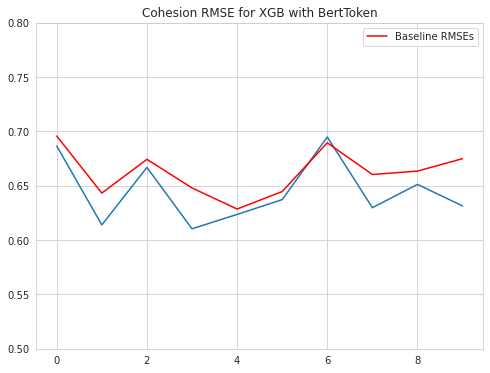

In [108]:
plt.figure(figsize=(8,6))

plt.plot(cv_rmses[:,0])
plt.plot(cv_rmses_baseline[:,0], 'r-', label="Baseline RMSEs")
plt.legend()
plt.ylim(.5, .8)
plt.title('Cohesion RMSE for XGB with BertToken')

plt.show()

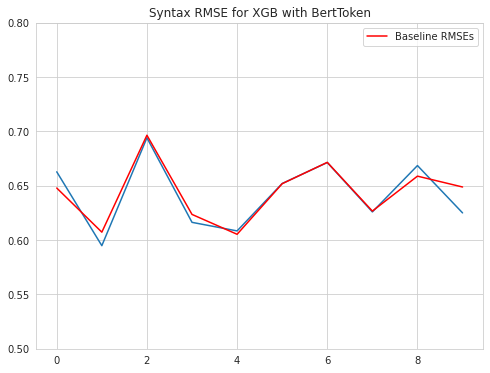

In [109]:
plt.figure(figsize=(8,6))

plt.plot(cv_rmses[:,1])
plt.plot(cv_rmses_baseline[:,1], 'r-', label="Baseline RMSEs")
plt.legend()
plt.ylim(.5, .8)
plt.title('Syntax RMSE for XGB with BertToken')

plt.show()

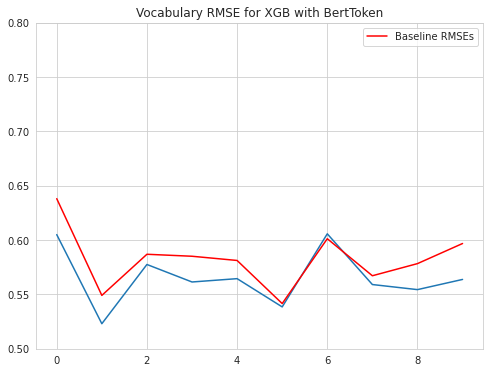

In [110]:
plt.figure(figsize=(8,6))

plt.plot(cv_rmses[:,2])
plt.plot(cv_rmses_baseline[:,2], 'r-', label="Baseline RMSEs")
plt.legend()
plt.ylim(.5, .8)
plt.title('Vocabulary RMSE for XGB with BertToken')

plt.show()

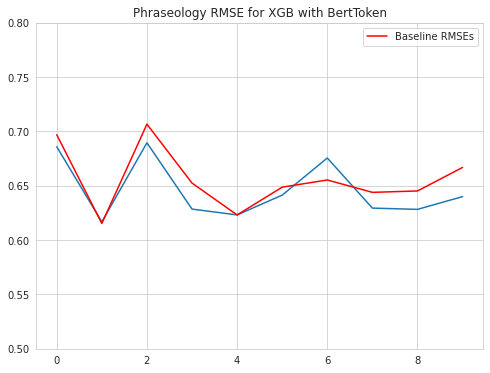

In [112]:
plt.figure(figsize=(8,6))

plt.plot(cv_rmses[:,3])
plt.plot(cv_rmses_baseline[:,3], 'r-', label="Baseline RMSEs")
plt.legend()
plt.ylim(.5, .8)
plt.title('Phraseology RMSE for XGB with BertToken')

plt.show()

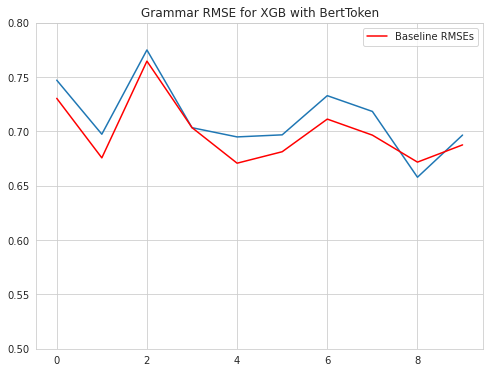

In [113]:
plt.figure(figsize=(8,6))

plt.plot(cv_rmses[:,4])
plt.plot(cv_rmses_baseline[:,4], 'r-', label="Baseline RMSEs")
plt.legend()
plt.ylim(.5, .8)
plt.title('Grammar RMSE for XGB with BertToken')

plt.show()

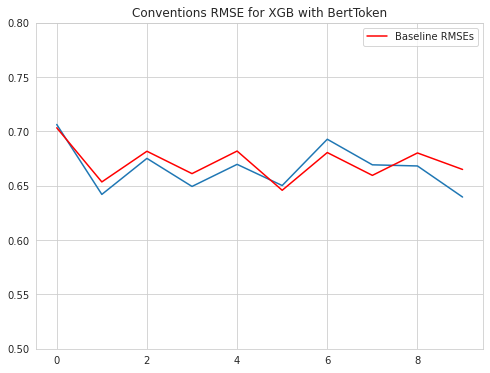

In [114]:
plt.figure(figsize=(8,6))

plt.plot(cv_rmses[:,5])
plt.plot(cv_rmses_baseline[:,5], 'r-', label="Baseline RMSEs")
plt.legend()
plt.ylim(.5, .8)
plt.title('Conventions RMSE for XGB with BertToken')

plt.show()